# Set up environment and import packages



In [ ]:
!python -m pip install --quiet --upgrade pip
!pip install mindscope_utilities --quiet --upgrade

####  import packages we need later in the notebook

In [4]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

# Load the session and experiment summary tables

The AllenSDK provides functionality for downloading tables that describe all sessions and experiments (individual imaging planes) in the Visual Behavior 2P dataset. We first download the data cache:

In [5]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

ophys_session_table.csv: 100%|██████████| 227k/227k [00:00<00:00, 4.74MMB/s]
behavior_session_table.csv: 100%|██████████| 1.21M/1.21M [00:00<00:00, 14.6MMB/s]
ophys_experiment_table.csv: 100%|██████████| 610k/610k [00:00<00:00, 11.2MMB/s]
ophys_cells_table.csv: 100%|██████████| 4.29M/4.29M [00:00<00:00, 15.4MMB/s]


- `Ophys_session_table` contains metadata describing imaging sessions. If more than one plane was imaged during a session, one ophys session id will be associated multiple ophys experiment ids. Each ophys session id will also have a unique behavior session id. 
- `Behavior_session_table` contains metadata describing behavioral sessions, which may or may not be during imaging. Behavior session ids that do not have ophys session ids were training sessions. 
- `Ophys_experiment_table` contains metadata describing imaging experiments (aka imaging planes). When mesoscope is used, one ophys session may contain up to 8 unique experiments (two visual areas by four imaging depths). Some imaging planes may not be released due to quality control issues, thus each ophys session id is associated with anywhere from one to eight unique experiment ids. Ophys experiment ids are unique and do not repeat across sessions. To find the same imaging plane that was matched across multiple sessions, use the `ophys_container_id` column that can be found in both `ophys_session_table` and `ophys_experiment_table`. 

Then we can access the session and experiment tables directly.

Note that a 'session' is a single behavioral session. Sessions that are performed on the mesoscope will have multiple (up to 8) 'experiments' associated with them, where an experiment is a distinct imaging plane. 


##### Available data includes: 
*   The cell `trace` aligned to stimulus (or omission) onset in a [-1.25, 1.5] second window around onset time
    *   Cell traces are in units of delta F/F, the change in fluorescence relative to baseline 
*   The `trace_timestamps` for each trial, aligned to stimulus or omission onset
*   The `mean_response` on a given trial in a 500ms window after stimulus onset
*   The `baseline_response` on a given trial in a 500ms window before stimulus onset
*   The `image_name` for each trial. Trials where the stimulus was omitted have `image_name` = `omitted`
*   The `mean_running_speed` in a 500ms window after stimulus onset
*   The `mean_pupil_area` in a 500ms window after stimulus onset
*   The `response_latency` when the mouse licked after stimulus onset
*   Whether or not the trial was `rewarded`
*   Whether or not the trial `is_change`
*   Whether or not the trial was `omitted`

#### Cell and session level metadata includes: 

*   The `stimulus_presentations_id` indicating the trial number within the session
*   The `cell_specimen_id` which is the unique identifier for each cell (note that a cell can be imaged in multiple sessions; if that's the case, the same cell_specimen_id appears in multiple sessions)
*   The `cre_line` indicating the cell type 
  *   `Sst-IRES-Cre` labels SST inhibitory cells
  *   `Vip-IRES-Cre` labels VIP inhibitory cells
  *   `Slc17a7-IRES-Cre` labels excitatory cells
*   The `imaging_depth` indicating the cortical depth where the cell was located
*   The `targeted_structure` indicating the cortical area the cell was from
*   The `session_type` indicating the session order and image set
*   The `exposure_level` which tells you whether the image set was familiar or novel
*   The `mouse_id` indicating which mouse the cell came from
*   The `ophys_session_id` indicating the recording day for that trial
*   The `ophys_experiment_id` indicating which imaging plane within the session that the cell came from
*   The `ophys_container_id` which links the same imaging plane recorded across multiple sessions. Cells that are imaged across multiple sessions will have the same `cell_specimen_id`. 


 

In [24]:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()
behavior_table = cache.get_behavior_session_table()

We can then view the contents of the session table. Note that this contains a lot of useful metadata about each session. One of the columns, ophys_experiment_id provides a list of the experiments (aka imaging planes) that are associated with each session.

In [11]:
print(session_table.keys())
session_table.head()

Index(['equipment_name', 'full_genotype', 'mouse_id', 'reporter_line',
       'driver_line', 'sex', 'age_in_days', 'cre_line', 'indicator',
       'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'behavior_session_id', 'ophys_experiment_id', 'ophys_container_id',
       'project_code', 'date_of_acquisition', 'session_type'],
      dtype='object')


,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,behavior_session_id,ophys_experiment_id,ophys_container_id,project_code,date_of_acquisition,session_type
ophys_session_id,,,,,,,,,,,,,,,,,,,
951410079,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0.0,65.0,0.0,951520319,"[951980471, 951980473, 951980475, 951980479, 9...","[1018028360, 1018028345, 1018028357, 101802834...",VisualBehaviorMultiscope,2019-09-20 09:45:29.897856,OPHYS_1_images_A
952430817,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,209.0,Sst-IRES-Cre,GCaMP6f,2.0,0.0,66.0,1.0,952554548,"[953659743, 953659745, 953659749, 953659752]","[1018028357, 1018028345, 1018028339, 1018028354]",VisualBehaviorMultiscope,2019-09-23 08:13:07.627573,OPHYS_2_images_A_passive
954954402,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,Sst-IRES-Cre,GCaMP6f,3.0,0.0,67.0,2.0,953982960,"[958527464, 958527471, 958527474, 958527479, 9...","[1018028360, 1018028342, 1018028357, 101802835...",VisualBehaviorMultiscope,2019-09-24 16:00:00.000000,OPHYS_3_images_A
955775716,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,212.0,Sst-IRES-Cre,GCaMP6f,3.0,1.0,68.0,3.0,956010809,"[956941841, 956941844, 956941846]","[1018028342, 1018028339, 1018028345]",VisualBehaviorMultiscope,2019-09-26 08:44:37.199778,OPHYS_3_images_A
957020350,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,213.0,Sst-IRES-Cre,GCaMP6f,4.0,0.0,0.0,4.0,957032492,"[957759562, 957759564, 957759566, 957759570, 9...","[1018028354, 1018028345, 1018028360, 101802834...",VisualBehaviorMultiscope,2019-09-27 08:28:05.415005,OPHYS_4_images_B


In [12]:
print(experiment_table.keys())
experiment_table.head()

Index(['equipment_name', 'full_genotype', 'mouse_id', 'reporter_line',
       'driver_line', 'sex', 'age_in_days', 'cre_line', 'indicator',
       'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'ophys_session_id', 'behavior_session_id', 'ophys_container_id',
       'project_code', 'imaging_depth', 'targeted_structure',
       'date_of_acquisition', 'session_type', 'experience_level', 'passive',
       'image_set', 'file_id'],
      dtype='object')


,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,experience_level,passive,image_set,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,,,,
951980486,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0.0,65.0,0.0,951410079,951520319,1018028360,VisualBehaviorMultiscope,300,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,Familiar,False,A,1085400869
951980473,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0.0,65.0,0.0,951410079,951520319,1018028345,VisualBehaviorMultiscope,225,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,Familiar,False,A,1085400919
951980481,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0.0,65.0,0.0,951410079,951520319,1018028357,VisualBehaviorMultiscope,225,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,Familiar,False,A,1085400972
951980471,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0.0,65.0,0.0,951410079,951520319,1018028342,VisualBehaviorMultiscope,150,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,Familiar,False,A,1085394308
951980475,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0.0,65.0,0.0,951410079,951520319,1018028339,VisualBehaviorMultiscope,75,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,Familiar,False,A,1085400920


In [25]:
print(behavior_table.keys())
behavior_table.head()

Index(['equipment_name', 'full_genotype', 'mouse_id', 'reporter_line',
       'driver_line', 'sex', 'age_in_days', 'cre_line', 'indicator',
       'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'ophys_session_id', 'ophys_experiment_id', 'ophys_container_id',
       'project_code', 'date_of_acquisition', 'session_type', 'file_id'],
      dtype='object')


,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,ophys_experiment_id,ophys_container_id,project_code,date_of_acquisition,session_type,file_id
behavior_session_id,,,,,,,,,,,,,,,,,,,,
870987812,BEH.D-Box1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,80.0,Sst-IRES-Cre,GCaMP6f,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,2019-05-17 14:46:33.550,TRAINING_0_gratings_autorewards_15min,1.085368e+09
872953842,BEH.D-Box1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,84.0,Sst-IRES-Cre,GCaMP6f,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,2019-05-21 13:22:20.613,TRAINING_1_gratings,1.085368e+09
873774125,BEH.D-Box1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,85.0,Sst-IRES-Cre,GCaMP6f,NaN,1.0,NaN,0.0,NaN,NaN,NaN,NaN,2019-05-22 13:19:52.005,TRAINING_1_gratings,1.085368e+09
874790261,BEH.D-Box1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,86.0,Sst-IRES-Cre,GCaMP6f,NaN,2.0,NaN,0.0,NaN,NaN,NaN,NaN,2019-05-23 13:40:31.405,TRAINING_1_gratings,1.085368e+09
875207834,BEH.D-Box1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,87.0,Sst-IRES-Cre,GCaMP6f,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,2019-05-24 11:06:39.332,TRAINING_1_gratings,1.085368e+09


# Load one example session
We are going to select one session from this table, session 854060305. This is a session with Sst-IRES-Cre mouse, which expressed GCaMP6f in Sst+ inhibitory interneurons. There were 6 simultaneously acquired imaging planes for this session. 
We can view metadata for this session as follows:

In [13]:
ophys_session_id = 854060305
session_table.loc[ophys_session_id]

equipment_name                                                                MESO.1
full_genotype                          Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt
mouse_id                                                                      440631
reporter_line                                             Ai148(TIT2L-GC6f-ICL-tTA2)
driver_line                                                           [Sst-IRES-Cre]
sex                                                                                M
age_in_days                                                                    129.0
cre_line                                                                Sst-IRES-Cre
indicator                                                                    GCaMP6f
session_number                                                                   6.0
prior_exposures_to_session_type                                                  0.0
prior_exposures_to_image_set                                     

# Download all associated experiments

Each session consists of one or more 'experiments', in which each experiment is a single imaging plane

Each mesoscope session has up to 8 experiments associated with the session. We will load all sessions into a dictionary with the experiment IDs as the keys

The first time that this cell is run, the associated NWB files will be downloaded to your local `data_storage_directory`. Subsequent runs of this cell will be faster since the data will already be cached locally.

In [14]:
experiments = {}
ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
for ophys_experiment_id in ophys_experiment_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)

behavior_ophys_experiment_854759890.nwb: 100%|██████████| 233M/233M [00:05<00:00, 46.1MMB/s]
behavior_ophys_experiment_854759894.nwb: 100%|██████████| 255M/255M [00:05<00:00, 45.9MMB/s]
behavior_ophys_experiment_854759896.nwb: 100%|██████████| 240M/240M [00:05<00:00, 46.1MMB/s]
behavior_ophys_experiment_854759898.nwb: 100%|██████████| 259M/259M [00:06<00:00, 41.1MMB/s]
behavior_ophys_experiment_854759900.nwb: 100%|██████████| 242M/242M [00:05<00:00, 45.1MMB/s]
behavior_ophys_experiment_854759903.nwb: 100%|██████████| 254M/254M [00:06<00:00, 40.7MMB/s]


## Load neural data into memory


The cell below will load the neural data into memory in the pandas 'tidy' format by iterating over each of the 6 experiments and using some helpful tools from the `visual_behavior_ophys` module of the `mindscope_utilities` package that was imported above as `ophys`. 

It will also include a subset of metadata from `ophys_experiment_table` to facilitate splitting by depth, structure (aka cortical area), cre line (aka cell class), etc.

Note that 'tidy' data means that each row represents only one observation. Observations are stacked vertically. Thus, the `timestamps` colums will repeat for every cell in the dataset.

In [15]:
neural_data = []
for ophys_experiment_id in tqdm(experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    this_experiment = experiments[ophys_experiment_id]
    this_experiment_neural_data = ophys.build_tidy_cell_df(this_experiment)
    
    # add some columns with metadata for the experiment
    metadata_keys = [
        'ophys_experiment_id',
        'ophys_session_id',
        'targeted_structure',
        'imaging_depth',
        'equipment_name',
        'cre_line',
        'mouse_id',
        'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]
        
    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)
    
# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

100%|██████████| 6/6 [00:02<00:00,  2.46it/s]


In [16]:
len(neural_data)

2561543

In [17]:
neural_data.head()

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,10.52216,0.400583,0.0,0.0,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
1,10.61538,0.126125,0.0,0.0,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
2,10.70860,-0.083087,0.0,0.0,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
3,10.80182,0.158960,0.0,0.0,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
4,10.89504,0.301507,0.0,0.0,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M


- The `cell_roi_id` column contains unique roi ids for all cells in a given experiment, which do not repeat across ophys sessions. 
- The `cell_specimen_id` column contains unique ids for cells that were matched across ophys sessions. Thus, a cell that was imaged in more than one session has multiple roi ids but one cell specimen id. 

# Examine Cell IDs
We can get the unique Cell IDs in our dataset as follows:

In [18]:
cell_ids = neural_data['cell_specimen_id'].unique()
print('there are {} unique cells'.format(len(cell_ids)))
print('cell ids are: {}'.format(cell_ids))

there are 53 unique cells
cell ids are: [1086550481 1086551114 1086551301 1086557083 1086557639 1086559064
 1086558114 1086558224 1086558510 1086559206 1086557304 1086557208
 1086560061 1086559681 1086559885 1086559968 1086557470 1086547796
 1086547993 1086548118 1086554566 1086556653 1086558574 1086552296
 1086558071 1086556532 1086555222 1086558701 1086557434 1086556317
 1086555835 1086549726 1086553836 1086551540 1086551151 1086550544
 1086552709 1086553271 1086553602 1086555553 1086548072 1086553899
 1086547630 1086549303 1086549491 1086549813 1086549949 1086548658
 1086548969 1086551457 1086551645 1086550990 1086551209]


In [19]:
single_cell_timeseries = neural_data.query('cell_specimen_id == 1086557208')
single_cell_timeseries.head()

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,10.52216,0.218961,0.0,0.0,1080855724,1086557208,854759894,854060305,VISp,179,MESO.1,Sst-IRES-Cre,440631,M
1,10.61538,0.232865,0.0,0.0,1080855724,1086557208,854759894,854060305,VISp,179,MESO.1,Sst-IRES-Cre,440631,M
2,10.70860,-0.050186,0.0,0.0,1080855724,1086557208,854759894,854060305,VISp,179,MESO.1,Sst-IRES-Cre,440631,M
3,10.80182,0.239468,0.0,0.0,1080855724,1086557208,854759894,854060305,VISp,179,MESO.1,Sst-IRES-Cre,440631,M
4,10.89504,0.226356,0.0,0.0,1080855724,1086557208,854759894,854060305,VISp,179,MESO.1,Sst-IRES-Cre,440631,M


Each cell has three types of traces:
- `dff` column is the Calcium fluorescence signal, normalized to background fluorescence.
- `events` column is deconvolved events from dff trace, which approximates neural firing rate and removes the slow decay of the Calcium signal (for more details, you can read EVENT DETECTION section in [Visual Behavior whitepaper](https://portal.brain-map.org/explore/circuits/visual-behavior-2p)).
- `filtered_events` column is events smoothed with a half-gaussian kernel. 

In [39]:
ss = behavior_table.groupby(['mouse_id']).first()
ss['sex'].describe()

count     107
unique      2
top         M
freq       65
Name: sex, dtype: object

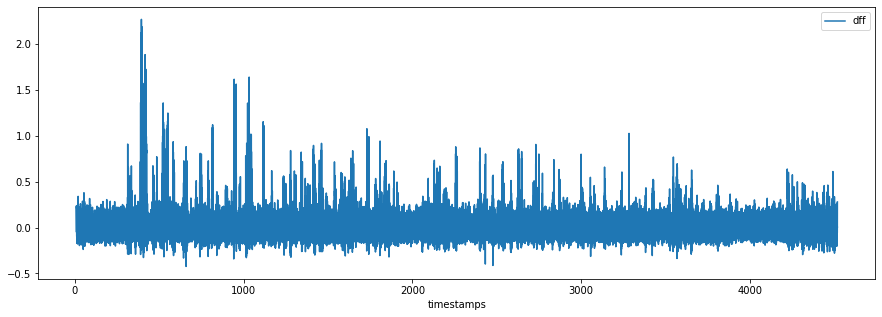

In [41]:
fig, ax = plt.subplots(figsize=(15,5))
single_cell_timeseries.plot(
    x = 'timestamps',
    y = 'dff',
    ax = ax
)

In [42]:
stimulus_table = experiments[ophys_experiment_ids[0]].stimulus_presentations.drop(columns = ['image_set']) # dropping the 'image_set' column to avoid confusion. Image_set column contains a unique string for set of images presented in a session.
stimulus_table.head(10)

,start_time,stop_time,duration,image_name,image_index,is_change,omitted,start_frame,end_frame
stimulus_presentations_id,,,,,,,,,
0,310.55053,310.80074,0.25021,im000,0,False,False,17986,18001.0
1,311.30115,311.55135,0.25020,im000,0,False,False,18031,18046.0
2,312.05179,312.30200,0.25021,im000,0,False,False,18076,18091.0
3,312.80242,313.05262,0.25020,im000,0,False,False,18121,18136.0
4,313.55303,313.80324,0.25021,im000,0,False,False,18166,18181.0
5,314.30362,314.55385,0.25023,im000,0,False,False,18211,18226.0
6,315.05426,315.30446,0.25020,im000,0,False,False,18256,18271.0
7,315.80487,316.05507,0.25020,im000,0,False,False,18301,18316.0
8,316.55547,316.80569,0.25022,im000,0,False,False,18346,18361.0


## Describe stimulus omissions
An important feature of the task is that stimuli are shown at a very regular cadence (250 ms on, 500 ms off), but stimuli are randomly omitted with a probability of ~5%. These unexpected and random stimulus omissions could be perceived as an expectation violation by the mouse.

Omitted stimuli are denoted in the `stimulus_table` by the `omitted` column. `True` means that the stimulus that would have been shown at that time was actually omitted (and was replaced by an extended gray screen between stimuli).

We can look at the first 10 examples of omitted stimuli as follows. Note that each 'omitted' stimulus still has a 'start_time' and a 'stop_time' associated with it. This actually represents the time that a stimulus would have been shown, had it not been omitted.

Stimulus omissions are also indicated in the `image_name` column by the string `omitted`

In [43]:
stimulus_table.query('is_change==@True')

,start_time,stop_time,duration,image_name,image_index,is_change,omitted,start_frame,end_frame
stimulus_presentations_id,,,,,,,,,
11,318.80729,319.05750,0.25021,im045,4,True,False,18481,18496.0
24,328.56529,328.81550,0.25021,im031,6,True,False,19066,19081.0
36,337.58929,337.83953,0.25024,im106,1,True,False,19607,19622.0
58,354.10278,354.35301,0.25023,im045,4,True,False,20597,20612.0
72,364.61139,364.86163,0.25024,im075,2,True,False,21227,21242.0
...,...,...,...,...,...,...,...,...,...
4736,3866.25385,3866.50401,0.25016,im031,6,True,False,231154,231169.0
4746,3873.75998,3874.01018,0.25020,im000,0,True,False,231604,231619.0
4758,3882.76729,3883.01754,0.25025,im045,4,True,False,232144,232159.0


# Create an event triggered response dataframe relative to omissions
If we want to see how a given cell responds when regularly flashed stimuli are omitted, we can calculate the response around each of the stimulus omissions. The `mindscope_utilities` package has a convenience function to do this. We give the function:
* a dataframe of interest (containing activity from one cell)
* the t and y values of interest
* the event times
* how much time before and after each event we are interested in
* the desired sampling rate of the output - this is the rate onto which the response will be interpolated

The function will return a new dataframe with the response for the given cell, aligned to each of the events.

In [44]:
cell_id = cell_ids[11]
etr = mindscope_utilities.event_triggered_response(
    data = neural_data.query('cell_specimen_id == @cell_id'),
    t = 'timestamps',
    y = 'dff',
    event_times = stimulus_table.query('omitted')['start_time'],
    t_before=3,
    t_after=3,
    output_sampling_rate = 50,
)
etr

,time,dff,event_number,stimulus_presentations_id,event_time
0,-3.00,0.043293,0,61,356.33793
1,-2.98,0.043293,0,61,356.33793
2,-2.96,0.043293,0,61,356.33793
3,-2.94,0.033406,0,61,356.33793
4,-2.92,0.017993,0,61,356.33793
...,...,...,...,...,...
55680,2.92,0.005114,184,4796,3911.29062
55681,2.94,0.003336,184,4796,3911.29062
55682,2.96,0.001558,184,4796,3911.29062
55683,2.98,0.001321,184,4796,3911.29062


We can see that the output has colums for
* `time` - this is our new timebase relative to the events. In this case, it ranges from -3 to 3
* `dff` - this is the deltaF/F value surrounding each event, interpolated onto the new timebase. If, when calling the `event_triggered_response` function we had passed `y = 'events'`, this column would be events instead of dff.
* `event_number` - this is an integer representing the count of each event. In this example, there were 185 omissions, so they are numbered from 0 to 184
* `event_time` - this is the time of each event



The output format of the `event_triggered_response` function is designed to plug directly into Seaborn's `lineplot` plotting function. We can then view the mean response to omitted stimuli with 95% confidence intervals very easily:

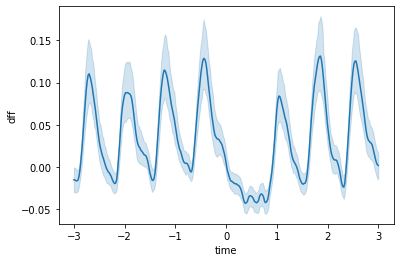

In [45]:
sns.lineplot(
    data=etr,
    x='time',
    y='dff',
    n_boot=500
)

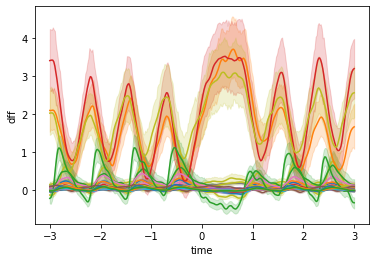

In [48]:

for cell_id in cell_ids:
  etr = mindscope_utilities.event_triggered_response(
      data = neural_data.query('cell_specimen_id == @cell_id'),
      t = 'timestamps',
      y = 'dff',
      event_times = stimulus_table.query('omitted')['start_time'],
      t_before=3,
      t_after=3,
      output_sampling_rate = 50,
  )
  sns.lineplot(
    data=etr,
    x='time',
    y='dff',
    n_boot=500
  )


Note that the regular, image-driven responses with a 750 ms inter-stimulus interval are visible everywhere except at t=0, which is when the unexpectedly omitted stimulus occured.

### Make a function to plot an event triggered average in one line

If we make a wrapper function that combines the process of calculating and plotting the event triggered response, it can be called in a single line below. By having `event_query` input variable, we can use this function to plot responses to any event of interest (omisisons, changes, hits/misses, specific images, etc)

In [69]:
def make_event_triggered_plot(df, x, y, event_query, ax, t_before=3, t_after=3):
    etr = mindscope_utilities.event_triggered_response(
        data = df,
        t = 'timestamps',
        y = y,
        event_times = stimulus_table.query(event_query)['start_time'],
        t_before=t_before,
        t_after=t_before,
        output_sampling_rate = 50,
    )
    sns.lineplot(
        data=etr,
        x=x,
        y=y,
        n_boot=500,
        ax=ax,
        legend='brief'
    )

Now plot the omission triggered response for the same cell using filtered events (these events extracted from the deltaF/F timeseries using an event extraction algorithm, then smoothed with a half-gaussian kernel) instead of dff.

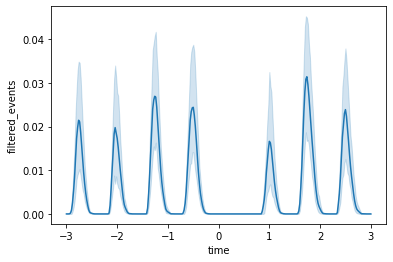

In [50]:
cell_id = cell_ids[11]
fig, ax = plt.subplots()
make_event_triggered_plot(
    df = neural_data.query('cell_specimen_id == @cell_id'), 
    x = 'time', 
    y = 'filtered_events', 
    event_query = 'omitted', 
    ax=ax
)

100%|██████████| 10/10 [00:41<00:00,  4.14s/it]


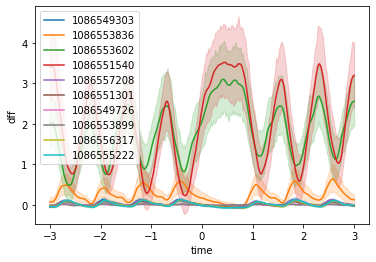

In [80]:
np.random.seed(0)
fig, ax = plt.subplots()
t = np.random.choice(cell_ids, size=10, replace=False)
for cell_id in tqdm(t):
    make_event_triggered_plot(
        df = neural_data.query('cell_specimen_id == @cell_id'), 
        x = 'time', 
        y = 'dff', 
        event_query = 'omitted', 
        ax=ax
    )
ax.legend(labels=t)

Interestingly, not all SST cells in this session do the same thing! 

## Calculate the mean response for each of the individual imaging planes in this experiment
By iterating over experiment IDs, we can also calculate the mean response for each of the 6 imaging planes. Do Sst cells in different visual areas respond to omissions in a distinct way? 

We will first use a Pandas `groupby` and `mean` operations to get the mean timeseries for each cell in that imaging plane:

In [52]:
mean_dff_by_experiment = (
    neural_data
    .groupby(['ophys_experiment_id','timestamps'])['dff']
    .mean()
    .reset_index()
)

In [53]:
mean_dff_by_experiment.head()

,ophys_experiment_id,timestamps,dff
0,854759890,10.52216,0.387612
1,854759890,10.61538,0.203569
2,854759890,10.70860,0.035257
3,854759890,10.80182,0.357586
4,854759890,10.89504,0.146397


In [55]:
for cell_id in cell_ids:
  etr = neural_data.query('cell_specimen_id == @cell_id')
  print(cell_id,' ',etr['dff'].var())


1086550481   0.08426224853252272
1086551114   0.8205993936439021
1086551301   0.024682409858207688
1086557083   0.011423793316327655
1086557639   0.01011512086684083
1086559064   0.04824129658094194
1086558114   0.015335380300928297
1086558224   0.005818979428926565
1086558510   1.2483531984699354
1086559206   0.036567706755863606
1086557304   0.018898022711612675
1086557208   0.022485494711652215
1086560061   0.0093220018778924
1086559681   0.019349920437789592
1086559885   0.045862257443367464
1086559968   0.016268863038238348
1086557470   0.14941248882719738
1086547796   0.026990586252999056
1086547993   0.048742666207095324
1086548118   0.08162968537544688
1086554566   0.014339416260865986
1086556653   11.381193833085291
1086558574   0.013259636257565748
1086552296   0.014035263870539097
1086558071   0.02940310050790098
1086556532   0.010227887523743588
1086555222   0.02508463583539954
1086558701   0.023441329248039343
1086557434   0.3603066508325873
1086556317   0.0176331642101666

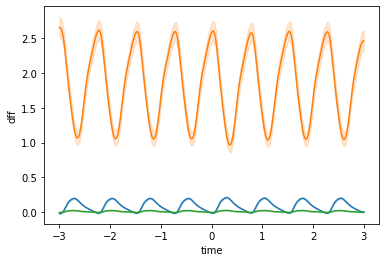

In [67]:
ids=[1086550481, 1086553602, 1086550544]
fig, ax = plt.subplots()
for id in ids:
  make_event_triggered_plot(
          df = neural_data.query('cell_specimen_id == @id'), 
          x = 'time', 
          y = 'dff', 
          event_query ='omitted == @False', 
          ax=ax
      )

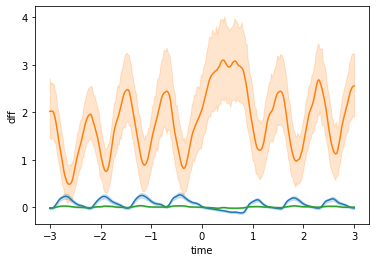

In [73]:
ids=[1086550481, 1086553602, 1086550544]
fig, ax = plt.subplots()
for id in ids:
  make_event_triggered_plot(
          df = neural_data.query('cell_specimen_id == @id'), 
          x = 'time', 
          y = 'dff', 
          event_query ='omitted == @True', 
          ax=ax
      )

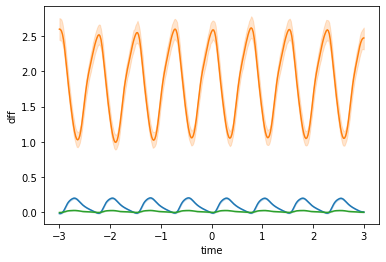

In [72]:
ids=[1086550481, 1086553602, 1086550544]

fig, ax = plt.subplots()
for id in ids:
  make_event_triggered_plot(
          df = neural_data.query('cell_specimen_id == @id'), 
          x = 'time', 
          y = 'dff', 
          event_query ='is_change', 
          ax=ax
      )

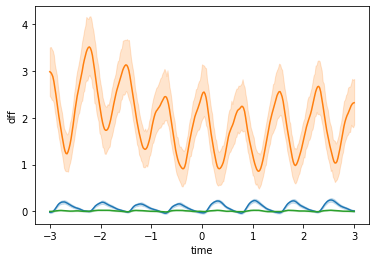

In [71]:
ids=[1086550481, 1086553602, 1086550544]
fig, ax = plt.subplots()
for id in ids:
  make_event_triggered_plot(
          df = neural_data.query('cell_specimen_id == @id'), 
          x = 'time', 
          y = 'dff', 
          event_query ='is_change', 
          ax=ax
      )

100%|██████████| 5/5 [01:55<00:00, 23.12s/it]


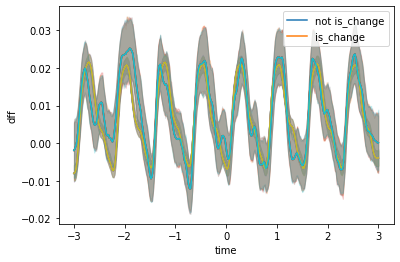

In [79]:
fig, ax = plt.subplots()
for cell_id in tqdm(np.random.choice(cell_ids, size=5, replace=False)):
    make_event_triggered_plot(
            df = neural_data.query('cell_specimen_id == @id'), 
            x = 'time', 
            y = 'dff', 
            event_query ='is_change == @False', 
            ax=ax
        )
    make_event_triggered_plot(
          df = neural_data.query('cell_specimen_id == @id'), 
          x = 'time', 
          y = 'dff', 
          event_query ='is_change', 
          ax=ax
      )

ax.legend(labels=('not is_change', 'is_change'), loc='best')
fig.show()

100%|██████████| 10/10 [03:28<00:00, 20.88s/it]


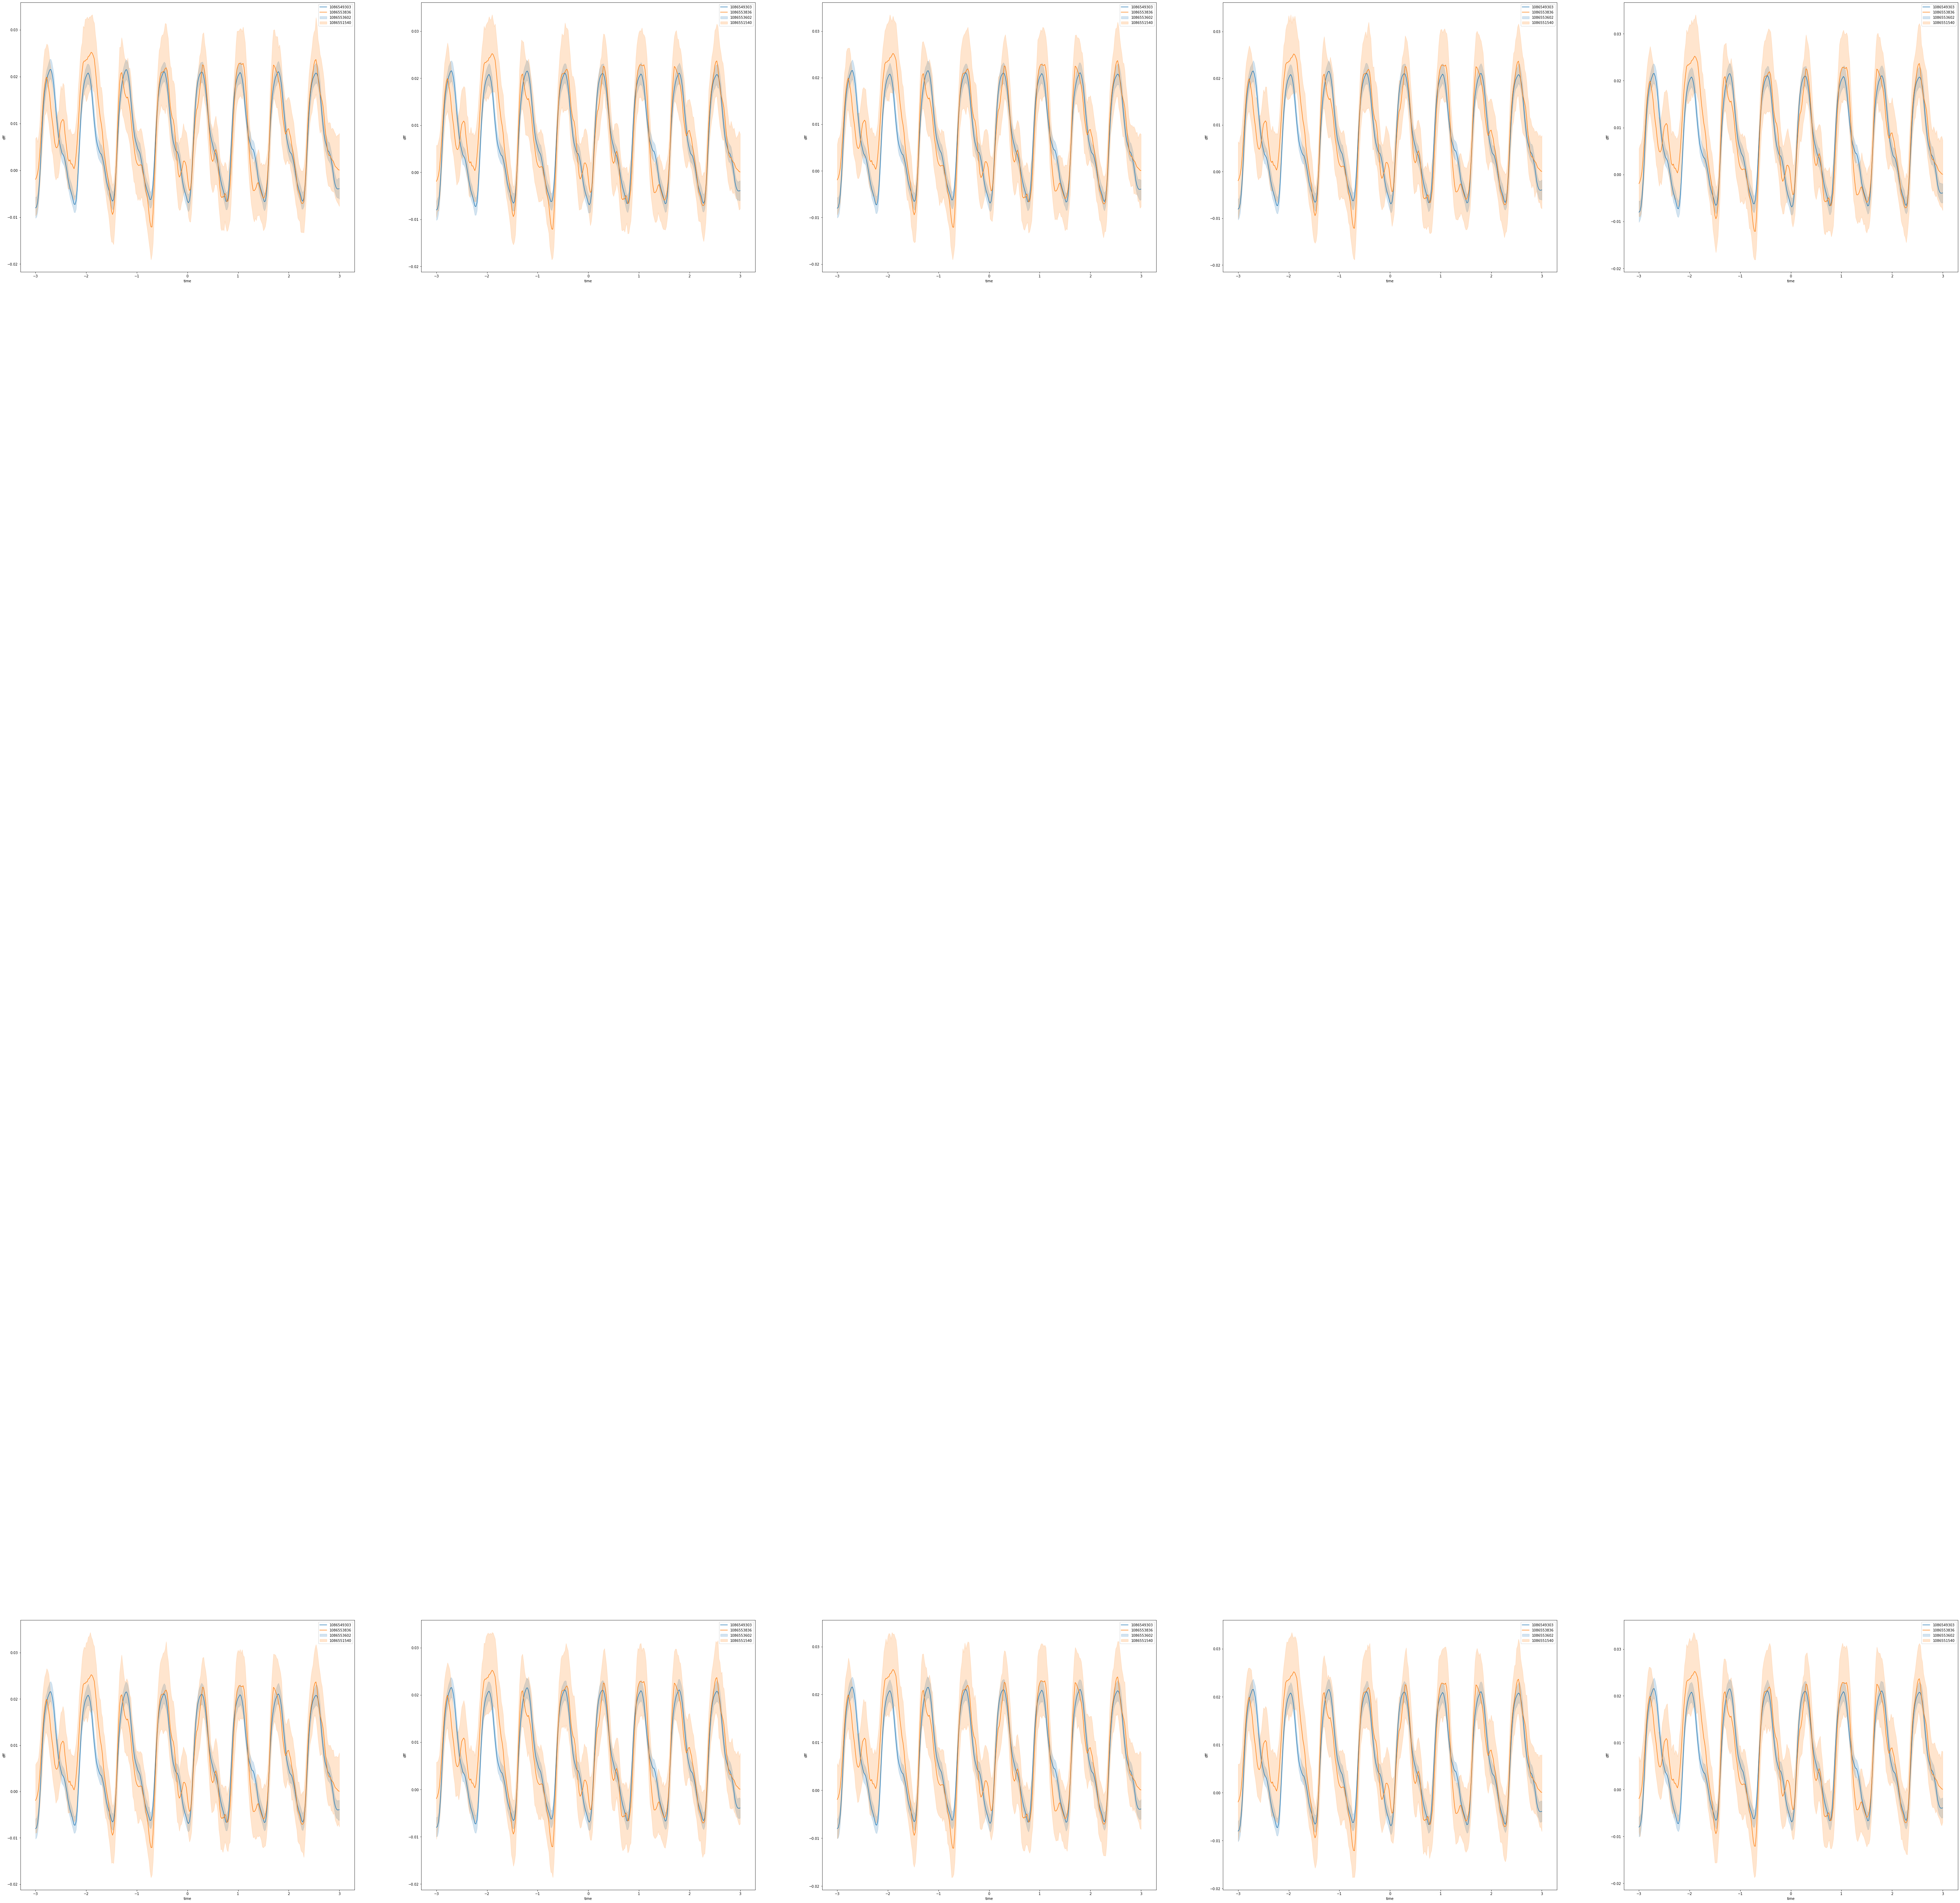

In [88]:
np.random.seed(0)
fig = plt.figure(figsize=(100,20))
fig.subplots_adjust(hspace=5)
t = np.random.choice(cell_ids, size=10, replace=False)
ind = 1
for cell_id in tqdm(t):
  ax = plt.subplot(2,5,ind)
  make_event_triggered_plot(
          df = neural_data.query('cell_specimen_id == @id'), 
          x = 'time', 
          y = 'dff', 
          event_query ='is_change == @False', 
          ax=ax
      )
  make_event_triggered_plot(
        df = neural_data.query('cell_specimen_id == @id'), 
        x = 'time', 
        y = 'dff', 
        event_query ='is_change', 
        ax=ax
    )
  ind+=1
  ax.legend(labels=t)